# Dogs vs. Cats

data source: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview

### import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, confusion_matrix, plot_confusion_matrix,classification_report

from tensorflow import keras 
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Input, Convolution2D, MaxPooling2D,Conv2D, Dropout, Flatten,Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import optimizers

# for model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

import warnings
warnings.filterwarnings('ignore')

### download kaggle data

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle competitions download dogs-vs-cats-redux-kernels-edition

100% 813M/814M [00:21<00:00, 40.4MB/s]
100% 814M/814M [00:21<00:00, 39.4MB/s]


In [3]:
!mkdir data
!unzip dogs-vs-cats-redux-kernels-edition.zip -d data

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.zip           
  inflating: data/train.zip          


### unzip images

In [ ]:
# run first to unzip images then comment it to avoid too many rows in output pdf

In [74]:
!unzip data/test.zip -d data/

In [75]:
!unzip data/train.zip -d data/

### Explore data

In [33]:
# ROWS = 64
# COLS = 64
# CHANNELS = 3 

In [34]:
TRAIN_DIR = '/content/data/train/'
TEST_DIR = '/content/data/test/'

In [76]:
# PATH = 'C:/Users/elsaivy/Predictives 6421/hw4'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

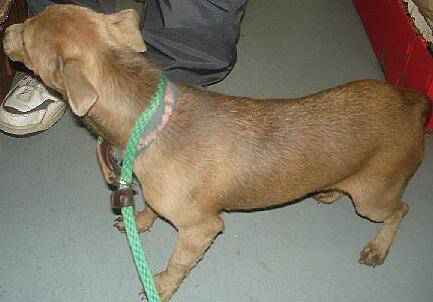

In [83]:
load_img(train_dogs[100])

In [86]:
labels = []
for i in os.listdir(TRAIN_DIR):
    if 'dog' in i:
        labels.append('dog')
    else:
        labels.append('cat')

### train test split

In [36]:
df = pd.DataFrame(data = {'img_filepath': os.listdir(TRAIN_DIR), 'label': labels})

In [37]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [38]:
train_df['label'].value_counts()

cat    10001
dog     9999
Name: label, dtype: int64

In [39]:
val_df['label'].value_counts()

dog    2501
cat    2499
Name: label, dtype: int64

### training

In [40]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='img_filepath',
    y_col='label',
    class_mode='categorical',
    target_size=(128,128),
    batch_size=15
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation

In [41]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    TRAIN_DIR, 
    x_col='img_filepath',
    y_col='label',
    class_mode='categorical',
    target_size=(128,128),
    batch_size=15
)

Found 5000 validated image filenames belonging to 2 classes.


### Testing

In [42]:
test_df = pd.DataFrame(data = {'img_filepath': os.listdir(TEST_DIR)})

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='img_filepath',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=15,
    shuffle=False
)

Found 12500 validated image filenames.


In [44]:
total_train = train_df.shape[0]
total_val = val_df.shape[0]
total_test = test_df.shape[0]

### Model - ResNet

The kaggle score is 0.40691 for ResNet.

In [46]:
model_resnet = Sequential()

model_resnet.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model_resnet.add(Dense(2, activation='softmax'))
model_resnet.layers[0].trainable = True

model_resnet.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [47]:
result_resnet = model_resnet.fit_generator(train_generator, validation_data=val_generator, validation_steps=total_val//16, epochs=5)

Epoch 1/5
1334/1334 [==============================] - 181s 126ms/step - loss: 1.2142 - accuracy: 0.5866 - val_loss: 1.5868 - val_accuracy: 0.5889
Epoch 2/5
1334/1334 [==============================] - 164s 123ms/step - loss: 0.6971 - accuracy: 0.6321 - val_loss: 0.7221 - val_accuracy: 0.6880
Epoch 3/5
1334/1334 [==============================] - 163s 122ms/step - loss: 0.6277 - accuracy: 0.6798 - val_loss: 0.6676 - val_accuracy: 0.7325
Epoch 4/5
1334/1334 [==============================] - 163s 122ms/step - loss: 0.5917 - accuracy: 0.7132 - val_loss: 0.5370 - val_accuracy: 0.7267
Epoch 5/5
1334/1334 [==============================] - 164s 123ms/step - loss: 0.5349 - accuracy: 0.7454 - val_loss: 0.4082 - val_accuracy: 0.8135


In [48]:
predict_resnet = model_resnet.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 39s 45ms/step


In [49]:
test_df['label_resnet'] = list(predict_resnet[:,1])

In [50]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id
0,787.jpg,0.170092,787
1,733.jpg,0.446220,733
2,11647.jpg,0.956697,11647
3,8469.jpg,0.098228,8469
4,5842.jpg,0.844444,5842


In [51]:
test_df[['id', 'label_resnet']].to_csv('resnet.csv', index = False)

### Model - VGG16

The kaggle score for VGG16 is 0.17642.

In [53]:
pre_trained_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)
model_vgg16 = Model(pre_trained_model.input, x)
model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [54]:
result_vgg16 = model_vgg16.fit_generator(train_generator, validation_data=val_generator,validation_steps=total_val//16,epochs=5)

Epoch 1/5
1334/1334 [==============================] - 171s 126ms/step - loss: 0.2655 - accuracy: 0.8873 - val_loss: 0.1190 - val_accuracy: 0.9547
Epoch 2/5
1334/1334 [==============================] - 166s 124ms/step - loss: 0.1388 - accuracy: 0.9458 - val_loss: 0.0958 - val_accuracy: 0.9647
Epoch 3/5
1334/1334 [==============================] - 165s 123ms/step - loss: 0.1094 - accuracy: 0.9567 - val_loss: 0.1109 - val_accuracy: 0.9579
Epoch 4/5
1334/1334 [==============================] - 167s 125ms/step - loss: 0.0909 - accuracy: 0.9654 - val_loss: 0.0900 - val_accuracy: 0.9650
Epoch 5/5
1334/1334 [==============================] - 166s 125ms/step - loss: 0.0800 - accuracy: 0.9675 - val_loss: 0.0777 - val_accuracy: 0.9690


In [55]:
predict_vgg16 = model_vgg16.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 38s 45ms/step


In [56]:
test_df['label_vgg16'] = list(predict_vgg16[:,1])

In [57]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id,label_vgg16
0,787.jpg,0.170092,787,4.357468e-08
1,733.jpg,0.446220,733,1.229546e-09
2,11647.jpg,0.956697,11647,1.000000e+00
3,8469.jpg,0.098228,8469,2.687595e-09
4,5842.jpg,0.844444,5842,9.281251e-01


In [58]:
test_df[['id', 'label_vgg16']].to_csv('vgg16.csv', index = False)

### Model - VGG19

The Kaggle result is 0.1806 for VGG19.

In [60]:
pre_trained_model = VGG19(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)
model_vgg19 = Model(pre_trained_model.input, x)
model_vgg19.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
model_vgg19.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                            

In [61]:
result_vgg19 = model_vgg19.fit_generator(train_generator, validation_data=val_generator,validation_steps=total_val//16,epochs=5)

Epoch 1/5
1334/1334 [==============================] - 175s 131ms/step - loss: 0.2762 - accuracy: 0.8777 - val_loss: 0.1163 - val_accuracy: 0.9556
Epoch 2/5
1334/1334 [==============================] - 173s 130ms/step - loss: 0.1284 - accuracy: 0.9501 - val_loss: 0.1006 - val_accuracy: 0.9609
Epoch 3/5
1334/1334 [==============================] - 175s 131ms/step - loss: 0.1037 - accuracy: 0.9589 - val_loss: 0.0865 - val_accuracy: 0.9658
Epoch 4/5
1334/1334 [==============================] - 181s 135ms/step - loss: 0.0840 - accuracy: 0.9665 - val_loss: 0.1182 - val_accuracy: 0.9551
Epoch 5/5
1334/1334 [==============================] - 174s 131ms/step - loss: 0.0774 - accuracy: 0.9697 - val_loss: 0.0745 - val_accuracy: 0.9718


In [62]:
predict_vgg19 = model_vgg19.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 39s 47ms/step


In [63]:
test_df['label_vgg19'] = list(predict_vgg19[:,1])

In [64]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id,label_vgg16,label_vgg19
0,787.jpg,0.170092,787,4.357468e-08,2.924514e-10
1,733.jpg,0.446220,733,1.229546e-09,8.315355e-10
2,11647.jpg,0.956697,11647,1.000000e+00,1.000000e+00
3,8469.jpg,0.098228,8469,2.687595e-09,1.577082e-11
4,5842.jpg,0.844444,5842,9.281251e-01,7.316673e-01


In [65]:
test_df[['id', 'label_vgg19']].to_csv('vgg19.csv', index = False)

### Combining 3 results

The kaggle score after ensembling is 0.14827.

In [66]:
res50=pd.read_csv("resnet.csv",index_col=[0])
vgg16=pd.read_csv("vgg16.csv",index_col=[0])
vgg19=pd.read_csv("vgg19.csv",index_col=[0])

In [95]:
final=pd.concat([res50,vgg16,vgg19],axis=1,join='inner')

In [96]:
final['label_new'] = final.mean(axis=1)
final.head()

,label_resnet,label_vgg16,label_vgg19,label_new
id,,,,
787,0.170092,4.357468e-08,2.924514e-10,0.056697
733,0.446220,1.229546e-09,8.315355e-10,0.148740
11647,0.956697,1.000000e+00,1.000000e+00,0.985566
8469,0.098228,2.687595e-09,1.577082e-11,0.032743
5842,0.844444,9.281251e-01,7.316673e-01,0.834746


In [97]:
final=final['label_new']
final=final.reset_index()
final.columns=['id','label']
final.head()

,id,label
0,787,0.056697
1,733,0.148740
2,11647,0.985566
3,8469,0.032743
4,5842,0.834746


In [98]:
final.to_csv("MSBA_Session1_YunChienYen.csv",index=False)

## Final result

In [71]:
result=pd.concat([test_df,final],axis=1,join='inner')

In [84]:
pic = result.iloc[200:250,:]
pic.reset_index(inplace=True)
pic.loc[pic['label']>=0.5,'category'] = 'Dog'
pic.loc[pic['label']<0.5,'category'] = 'Cat'

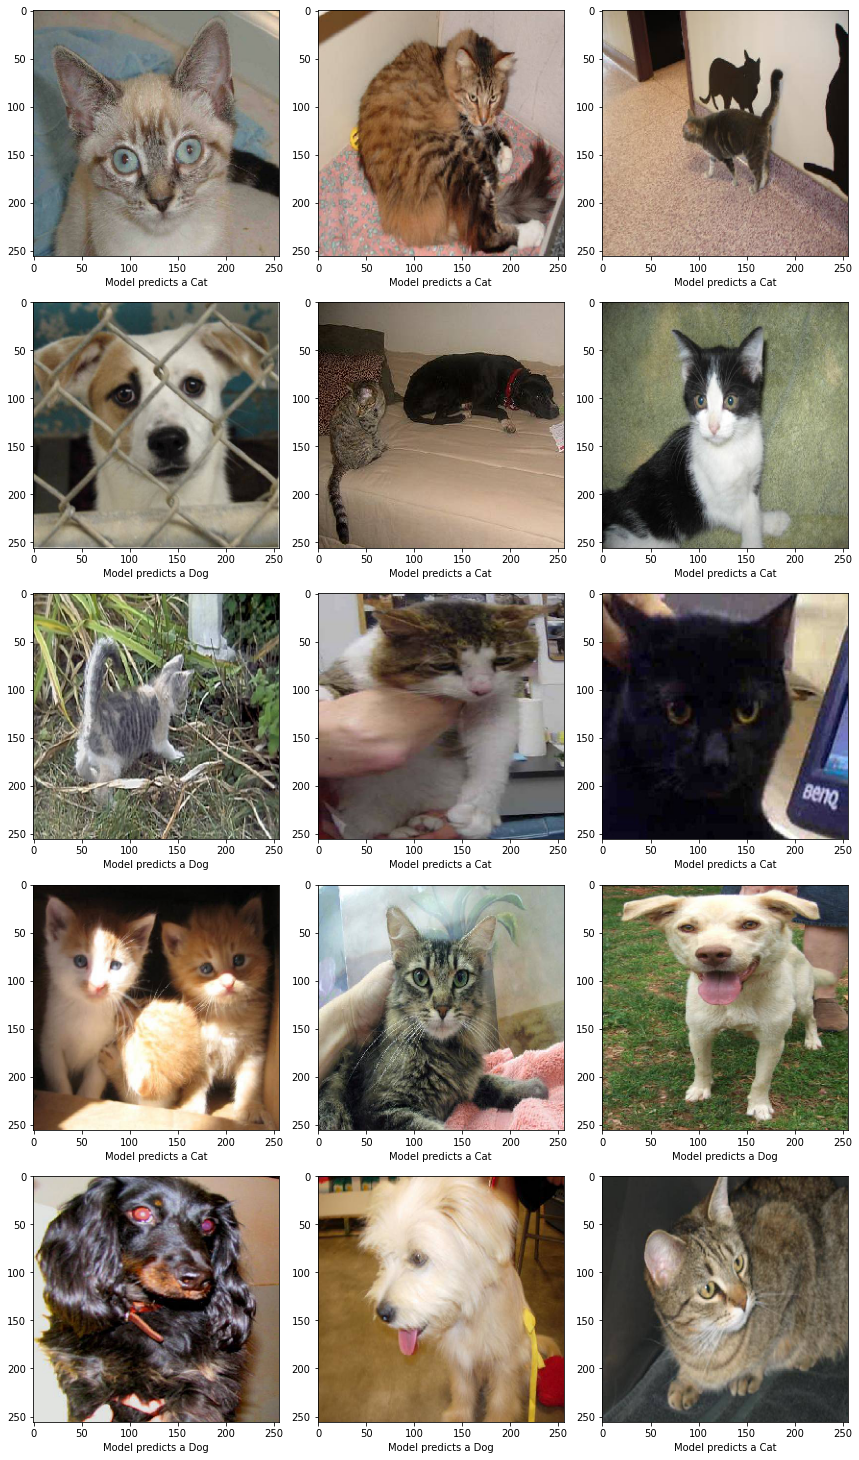

In [85]:
# view top 15 prediction result

pic = pic.head(15)
plt.figure(figsize=(12, 24))
for index, row in pic.iterrows():
    filename = row['img_filepath']
    category = row['category']
    img = load_img(TEST_DIR+filename, target_size=(256,256))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Model predicts a ' + "{}".format(category))
plt.tight_layout()
plt.show()